In [1]:
from __future__ import division
from influxdb import InfluxDBClient
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import seaborn as sns

In [2]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

def plot_alpha(data, alpha, **kwargs):
    run_mean = kwargs.get('running_mean', 1)
    ylims = kwargs.get('ylims', [0,100])
    fig, ax = plt.subplots()
    ar_dat = np.asarray(data[int(alpha*10)])
    av_dat = np.mean(ar_dat, axis=0)
    ma_dat = np.amax(ar_dat, axis=0)
    mi_dat = np.amin(ar_dat, axis=0)
    
    for i in range(len(ar_dat)):
        ax.plot(running_mean(ar_dat[i], run_mean), '-', color=a[i%len(a)], alpha=0.3, label=f'Run {i+1}')
    ax.plot(running_mean(av_dat, run_mean), color='k', label='Run Avg')
    #ax.fill_between(np.arange(len(av_dat)), mi_dat[0:len(av_dat)], ma_dat[0:len(av_dat)], facecolor = 'gray', alpha = 0.1)
    ax.legend(bbox_to_anchor=(1.0, .9))
    ax.set_ylim(ylims)
    plt.show()
    


In [3]:
file = open('record_uuid.txt', 'r')
ids = file.read().split('\n')

uuids = {}
for x in ids[:-2]:
    splitstring = x[1:-1].split(',')
    key = splitstring[0]
    uid = splitstring[1][0:36]
    if key not in uuids.keys():
        uuids[key] = [uid]
    else:
        uuids[key].append(uid)
        
client = InfluxDBClient('localhost', 8086, 'root', 'root', 'mdp')
data = []

for ind, i in enumerate(uuids.keys()):
    data.append([])
    for j in range(len(uuids[i])):
        uuid = uuids[i][j]
        query = f"select tot_rwd from run where id='{uuid}'"
        response = client.query(query=query)
        test = response.raw
        total_trial_reward = list(map(int, np.asarray(test['series'][0]['values'])[:, 1]))
        data[ind].append(total_trial_reward)

In [45]:
#dat = data[6]
a = sns.color_palette('Set1', len(dat))
store_params = []
for j in range(len(data)):
    dat = data[j]
    store_params.append([])
    for i in range(len(dat)):
        test_bloc = dat[i]
        smoothed_ = running_mean(test_bloc, 30)

        x_tb = np.arange(len(dat[i]))
        x_sm = np.arange(len(smoothed_))

        y_tb = [x/100 for x in test_bloc]
        y_sm = [x/max(smoothed_) for x in smoothed_]

        try:
            c2_guess = np.where(np.array(y_sm)>0.5)[0][0]
            popt, pcov = sc.optimize.curve_fit(sigmoid, x_sm, y_sm, p0 = [c2_guess,1])

            x = x_sm
            y = sigmoid(x, *popt)
            if popt[0] <0 or popt[0]>3000 or popt[1]>0.25:
                store_params[j].append([np.nan,np.nan])
            else:
                store_params[j].append([popt[0],popt[1]])
        except:
            y = np.zeros(len(x_sm))
            popt = 'none'
            store_params[j].append([np.nan,np.nan])
        


/home/annik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


'\n        if i == 0:\n            ax[i].plot(y_tb,\':\', color=a[i], alpha=0.2, label=\'raw\')\n            ax[i].plot(y_sm,color=a[i], label=\'sm\')\n            ax[i].plot(y, color=\'k\', alpha=0.5, label=\'fit\')\n            ax[i].annotate(f\'{np.round(popt[1]*100,2)}\', (5,0.6))\n        else:\n            ax[i].plot(y_tb,\':\', color=a[i], alpha=0.2)\n            ax[i].plot(y_sm,color=a[i])\n            ax[i].plot(y, color=\'k\', alpha=0.5)\n            if popt is not "none":\n                ax[i].annotate(f\'{np.round(popt[1]*100,2)}\', (5,0.6))\n        ax[i].set_ylim([0,1])\n\n    ax[0].legend(bbox_to_anchor = (1.02, 1.0))\n    plt.show()\n'

In [ ]:
'''
fig, ax = plt.subplots(len(dat),1, sharex=True, sharey=True)

        if i == 0:
            ax[i].plot(y_tb,':', color=a[i], alpha=0.2, label='raw')
            ax[i].plot(y_sm,color=a[i], label='sm')
            ax[i].plot(y, color='k', alpha=0.5, label='fit')
            ax[i].annotate(f'{np.round(popt[1]*100,2)}', (5,0.6))
        else:
            ax[i].plot(y_tb,':', color=a[i], alpha=0.2)
            ax[i].plot(y_sm,color=a[i])
            ax[i].plot(y, color='k', alpha=0.5)
            if popt is not "none":
                ax[i].annotate(f'{np.round(popt[1]*100,2)}', (5,0.6))
        ax[i].set_ylim([0,1])

    ax[0].legend(bbox_to_anchor = (1.02, 1.0))
    plt.show()
'''

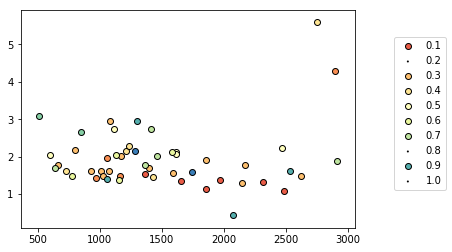

In [65]:
sp = np.asarray(store_params)
a = sns.color_palette('Spectral', len(sp))
b = [1,2,3,4,5,6,7,8,9,10]
for i in b:#range(len(sp)):
    for j in range(len(sp[i])):
        #print(sp[i][j])
        if j == 0:
            plt.scatter(sp[i][j][0], sp[i][j][1]*100, edgecolor='k', color=a[i%len(a)], label=np.round(i*0.1, 2))
        else:
            plt.scatter(sp[i][j][0], sp[i][j][1]*100, edgecolor='k', color=a[i%len(a)])
#plt.ylim([0,3.5])
plt.legend(bbox_to_anchor=(1.1,0.9))
plt.show()

In [ ]:
avg_data = []
se_data = []
min_data = []
max_data = []

fig, ax = plt.subplots()
 
a = sns.color_palette('Spectral', len(data))

for i in range(len(data)):
    ar_dat = np.asarray(data[i])
    avg_data = running_mean(np.mean(ar_dat, axis=0),30)
    se_data  = np.std(ar_dat, axis=0)
    min_data = np.amin(ar_dat, axis=0)
    max_data = np.amax(ar_dat, axis=0)
    
    ax.plot(avg_data, color = a[i], label=f"alpha={np.round(0.1*i, 2)} (n={len(ar_dat)})")
    
ax.legend(bbox_to_anchor=(1.0, .9))
plt.show()
plt.close()

plot_alpha(data, 0.3, running_mean = 30)

In [ ]:
sig_max = []
sig_max1 = []
fits = []
for i in range(len(data)):
    fits.append([])
    sig_max1.append([])
    for j in range(len(data[i])): 
        xdata = np.arange(len(data[i][j]))
        ydata = [x/100 for x in running_mean(data[i][j], 1)]
        
        try:
            popt, pcov = sc.optimize.curve_fit(sigmoid, xdata, ydata)
            x = xdata
            y = sigmoid(x, *popt)
            fits[i].append(y)
            max_deriv = list(np.diff(y)).index(max(np.diff(y)))
            sig_max.append([i, j, max_deriv])
            sig_max1[i].append(max_deriv)
            
        except:
            sig_max.append([i, j, np.nan])
            sig_max1[i].append(np.nan)
            fits[i].append([])
            pass
        
        
sig_max = np.asarray(sig_max)
sig_max1 = np.asarray(sig_max1)


slopes = []
for i in range(len(data)):
    print(sig_max1[i])
    slopes.append([])
    for j in range(len(data[i])):
        if np.nan is sig_max1[i][j]:
            slopes[i].append(np.nan)
            
        else:
            centro = sig_max1[i][j]
            buff = len(data[i][j])-centro
            if buff > 10:
                buff = 10
            dx = buff*2 -1
            dy = fits[i][j][centro+buff-1] - fits[i][j][centro-buff]
            slope = dy/dx
            slopes[i].append(100*slope)

fig, ax = plt.subplots(2,1, sharex=True)
for i in range(len(sig_max1)):
    for j in range(len(sig_max1[i])):
        if j == 0:
            ax[0].scatter(i, sig_max1[i][j], color = a[i], label=f'{i}')
        else:
            ax[0].scatter(i, sig_max1[i][j], color = a[i])
            if slopes[i][j] is np.nan:
                pass
            else:
                ax[1].scatter(i, slopes[i][j], color=a[i])

ax[0].legend(bbox_to_anchor=(1.0, .9))
#plt.title("Time of Sigmoid Derivative Max")
plt.show()


fig, ax = plt.subplots()
for i in range(len(sig_max1)):
    for j in range(len(sig_max1[i])):
        if j == 0:
            ax.scatter(sig_max1[i][j], slopes[i][j], s=100, color = a[i], edgecolor = 'k', label=f'{i}')
        else:
            ax.scatter(sig_max1[i][j], slopes[i][j], s=100, color = a[i], edgecolor = 'k')
            
ax.legend(bbox_to_anchor=(1.2,0.9))

for i in range(len(slopes)):
    print(np.round(slopes[i], 4))
    
for i in range(len(data)):
    plt.figure(i)
    for j in range(len(data[i])):
        lin_fit = [slopes[i][j]*(x - sig_max1[i][j]) + 0.5*(max(running_mean(data[i][j], 30))) for x in np.arange(3000)]
        plt.plot(running_mean(data[i][j], 30), color = 'k', alpha = 0.3)
        #plt.plot(max(running_mean(data[i][0], 30))*fits[i][0])
        plt.plot(lin_fit, color = a[i])
        plt.ylim([0,100])
    plt.title(f'Alpha = {i*0.1}')
    plt.show()
plt.close()

for i in range(len(data[10])):
    plt.plot(fits[10][i], color='orange')
    plt.plot(data[10][i], color='k', alpha =0.1)

alf = 0.2
plot_alpha(data, alf, running_mean = 1)

test_deriv = data[int(10*alf)]
for i in range(1):
    td = running_mean(np.diff(running_mean(test_deriv[i], 30),1), 2)
    dx = np.ones_like(td)
    plt.plot(td/dx, alpha = 0.3)
plt.show()